[View in Colaboratory](https://colab.research.google.com/github/tarosaku/sakutest/blob/master/stopsign_detection_test_new.ipynb)


Python2ならば動くが、Python3ではエラーになる　(2018.8.24時点)

##

(参考URL)

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_pets.md

https://www.petitmonte.com/python/ai_cup_ramen.html

https://qiita.com/watanabe0621/items/0b1cfa2d89c8321767e2

##

#TensorFlowのインストールガイドに従って、環境構築を行う。

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md

まずは、ライブラリのインストール

In [0]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install --user Cython
!pip install --user contextlib2
!pip install --user jupyter
!pip install --user matplotlib
!pip install --user lxml


TensorFlow modelsのインストール

In [0]:
cd /content

In [0]:
!rm -r models
!git clone https://github.com/tensorflow/models.git

COCO APIのインストール

In [0]:
!rm -r cocoapi
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/models/research/

ライブラリをパスへ追加

In [0]:
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

Protobufのコンパイル

In [0]:
cd /content/models/research

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

インストール完了テスト

In [0]:
!python object_detection/builders/model_builder_test.py

「OK」が出れば、環境構築完了

#ここから、データやモデルの準備

画像データとannotationsデータをアップロード（ローカル or googleドライブから）

※annotationはlabelImgを使って行った

In [0]:
# images.tar.gz,annotations.tar.gzをローカルからアップロードする場合
# show upload dialog (images.tar.gz,annotations.tar.gzを選択)
from google.colab import files
uploaded = files.upload()

In [0]:
# images.zip,annotations.zipをgoogledriveから読み込む場合
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# images.zip,annotations.zipをgoogledriveから読み込む（続き）
id = '1kM4myEkQ_4ecFTGwaWda7csycVac0MKt'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('images.zip')
id = '1wtU9-m1AWyoChnYDVT8Cb2ovsTUA6oC-'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('annotations.zip')

アップロードしたデータを解凍

In [0]:
!unzip images.zip
!unzip annotations.zip

必要なファイルのアップロード

In [0]:
rm faster_rcnn_resnet101_stopsign*

In [0]:
#3ファイル（stopsign_label_map.pbtxt、create_tf_record.py、faster_rcnn_resnet101_stopsign.config）
from google.colab import files
uploaded = files.upload()

TFRecordの作成

In [0]:
!python create_tf_record.py \
    --annotations_dir=`pwd`/annotations \
    --images_dir=`pwd`/images \
    --output_dir=`pwd` \
    --label_map_path=stopsign_label_map.pbtxt

TFRecord作成の確認（train.recordとeval.recordができている）

In [0]:
!ls -l *record*

事前学習モデルのダウンロード

ここでは、faster_rcnn_resnet101_coco_11_06_2017を利用

In [0]:
!wget http://storage.googleapis.com/download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_11_06_2017.tar.gz
!tar -xvf faster_rcnn_resnet101_coco_11_06_2017.tar.gz
!cp faster_rcnn_resnet101_coco_11_06_2017/model.ckpt.* .

TensorBoardの準備

In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

In [0]:
get_ipython().system_raw('tensorboard --logdir /content/models/research --host 0.0.0.0 --port 6006 &')
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


#ここから、トレーニングと評価の実行

トレーニング用フォルダの作成

In [0]:
!mkdir train

トレーニングと評価

In [0]:
# Python3用に修正したmodel_lib.pyをアップ
# 修正内容は、以下
# https://github.com/tensorflow/models/issues/4780
# https://github.com/guildai/models/commit/d88f1fb9cad472c38149f208b086ca90c1da0856

from google.colab import files
uploaded = files.upload()

!mv model_lib.py object_detection

In [0]:
# Python3の場合は、上のmodel_lib.pyをアップロードしてからこちらを実行。
!python object_detection/model_main.py \
    --pipeline_config_path=/content/models/research/faster_rcnn_resnet101_stopsign.config \
    --model_dir=/content/models/research/train \
    --num_train_steps=20000 \
    --num_eval_steps=100 \
    --alsologtostderr

In [0]:
#Python2の場合は、こちらを使って、バックグラウンドで実行できる。（Python3だとなぜか進まない）
get_ipython().system_raw('python object_detection/model_main.py \
    --pipeline_config_path=/content/models/research/faster_rcnn_resnet101_stopsign.config \
    --model_dir=/content/models/research/train \
    --num_train_steps=50000 \
    --num_eval_steps=100 \
    --alsologtostderr 2>&1 /content/log/tb.log &')

トレーニングが進んでいるかの確認。ファイルが増えていく。

（少し進むと、TensorBoardでも状況確認ができる）

In [0]:
!ls -l train

トレーニングのプロセスIDの確認(python2 object_detection/model_mが存在すれば実行中)

In [0]:
!ps -ef

バックグラウンド実行中のトレーニングを打ち切る場合、object_detection/model_main.pyのプロセスをkillして終了させる

In [0]:
!kill 583 #model_main.pyをkillする

#トレーニング結果の保存

TensorFlowグラフのエクスポート

NUM_CKPTを、実行したステップ数に変更する

In [0]:
!rm -r  exported_graphs; mkdir exported_graphs

In [0]:
NUM_CKPT = 8563

In [0]:
!cp train/model.ckpt-\{NUM_CKPT}.* .

In [0]:
!python object_detection/export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path faster_rcnn_resnet101_stopsign.config \
    --trained_checkpoint_prefix train/model.ckpt-\{NUM_CKPT} \
    --output_directory exported_graphs

エクスポートしたTensorFlowグラフをgoogleドライブに保存

In [0]:
!zip -r exp_g.zip exported_graphs

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'exp_g.zip'})
uploaded.SetContentFile('exp_g.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

#トレーニング結果を使って推論の実施

TensorFlowのチュートリアルを参考に、トレーニングしたモデルを使って推論を実行する

https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

ライブラリのインポート

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops

# This is needed to display the images.# This  
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

推論モデルの指定

In [0]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = 'exported_graphs/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('', 'stopsign_label_map.pbtxt')

NUM_CLASSES = 1

推論モデル・ラベルマップをメモリに読み込み

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

試したい画像をローカルからアップする

In [0]:
from google.colab import files
uploaded = files.upload()

アップした画像の名前を「image1.jpg」「image2.jpg」に変更する

In [0]:
!mv quick_safty_049.jpg object_detection/test_images/image1.jpg
!mv 19681100.jpg object_detection/test_images/image2.jpg

推論の実行

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

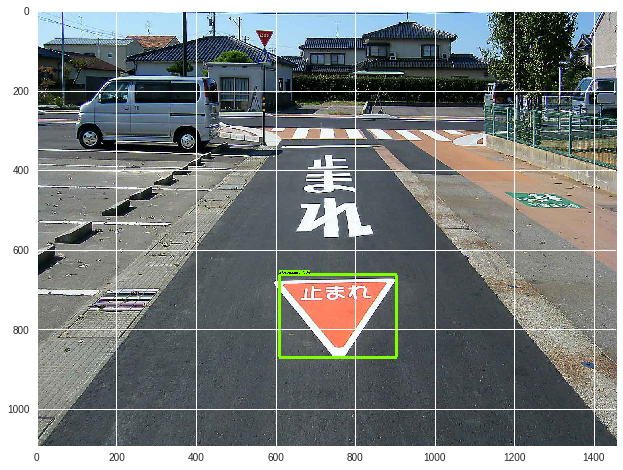

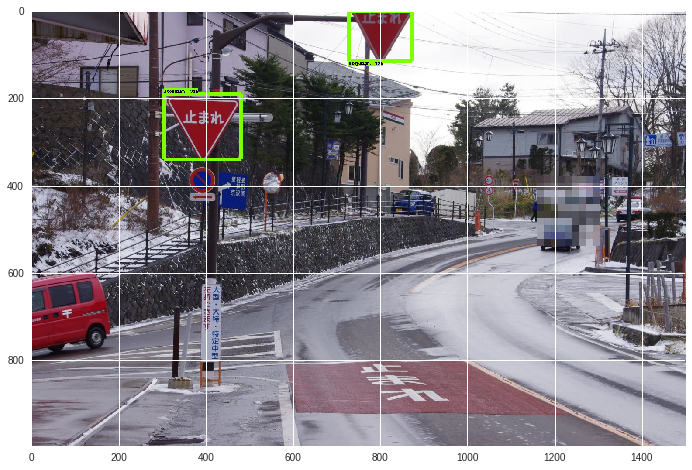

In [52]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)